In [1]:
# for MLE
import numpy as np
import optimagic as om
import numba

# for plotting
import matplotlib.pyplot as mpl

# main module
import sequence_jacobian as sj
from sequence_jacobian import AR, ShockDict
from sequence_jacobian import Prior, Uniform

#### Simulation Utilities

In [2]:
def simulate(impulses, outputs, T_sim):
    """
    impulses: list of ImpulseDicts, each an impulse to independent unit normal shock
    outputs: list of outputs we want in simulation
    T_sim: length of simulation

    simulation: dict mapping each output to length-T_sim simulated series
    """

    simulation = {}
    epsilons = [np.random.randn(T_sim+impulses[0].T-1) for _ in impulses]
    for o in outputs:
        simulation[o] = sum(
            simul_shock(imp[o], eps) for imp, eps in zip(impulses, epsilons)
        )
        
    return simulation

@numba.njit(parallel=True)
def simul_shock(dX, epsilons):
    """
    Take in any impulse response dX to epsilon shock, plus path of epsilons, and simulate
    """

    T = len(dX)
    T_eps = len(epsilons)
    dXtilde = np.empty(T_eps - T + 1) 
    
    dX_flipped = dX[::-1].copy()
    for t in numba.prange(T_eps - T + 1):
        dXtilde[t] = np.vdot(dX_flipped, epsilons[t:t + T])

    return dXtilde

#### Plotting Utilities

In [3]:
def plot_timeseries(data_dict, xlabel="Quarters", **kwargs):
    dims = (1,len(data_dict))
    mpl.figure(**kwargs)
    for i, (name, data) in enumerate(data_dict.items()):
        mpl.subplot(*dims, i+1)
        mpl.plot(data)
        mpl.title(name)
        mpl.xlabel(xlabel)
        mpl.axhline(y=0, color="#808080", linestyle=":")
    
    return mpl.tight_layout()

def plot_impulses(dict_of_impulsedicts, labels, series, dims, xlabel="Quarters", T=None, **kwargs):
    mpl.figure(**kwargs)
    for i, name in enumerate(series):
        mpl.subplot(*dims, i+1)
        
        for k, impulse_dict in dict_of_impulsedicts.items():
            mpl.plot(impulse_dict.get(name)[:T], label=labels[k])
        
        mpl.title(name)
        mpl.xlabel(xlabel)
        mpl.axhline(y=0, color="#808080", linestyle=":")

        if i == 0:
            mpl.legend()

    return mpl.tight_layout()

## Household Block

In [4]:
hh = sj.hetblocks.hh_sim.hh
make_grids = sj.hetblocks.hh_sim.make_grids

def income(Y, T, e_grid):
    # post-tax labor income
    y = (Y-T) * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])

## Fiscal Block

In [5]:
@sj.simple
def nkpc(pi, Y, X, C, kappa_w, vphi, frisch, markup_ss, eis, beta):
    piw = pi + X - X(-1)
    piwres = kappa_w * (vphi*(Y/X)**(1/frisch) - 1/markup_ss * X * C**-(1/eis)) + beta * piw(1) - piw
    return piwres, piw


@sj.simple
def monetary_taylor(pi, ishock, rss, phi_pi):
    i = rss + phi_pi * pi + ishock
    r_ante = i - pi(1)
    return i, r_ante


@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r


@sj.solved(unknowns={"B": (-1., 1.)}, targets=["Bres"], solver="brentq")
def fiscal_deficit_Trule(r, G, B, Tss, phi_T, Y):
    T = Tss + phi_T * (B(-1) - B.ss)
    Bres = (1 + r) * B(-1) + G - T - B
    return T, Bres

## HANK Model

In [6]:
@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt


ha = sj.create_model(
    [household_simple, nkpc, monetary_taylor, ex_post_rate, fiscal_deficit_Trule, mkt_clearing],
    name = "Simple HA Model"
)

## Calibration

In [7]:
calibration = {
    "eis": 0.5,         # elasticity of intertemporal substitution
    "frisch": 0.5,      # labor supply elasticity
    "markup_ss": 1.015, # steady state markup
    "phi_pi": 1.5,      # Taylor coefficient on inflation
    "kappa_w": 0.2,     # slope of the wage Phillips curve
    "phi_T": 0.1,       # adjustment coefficient in tax rule
    "rho_e": 0.92,      # persistence of idiosyncratic productivity shocks
    "sd_e": 0.92,       # standard deviation fo idiosyncratic productivity shocks
    "n_e": 11,          # number of productivity grid points
    "min_a": -1,        # minimum asset level on the grid
    "max_a": 1000,      # maximum asset level on the grid
    "n_a": 500,         # number of asset grid points
    "X": 1.,            # TFP
    "G": 0.,            # exogenous government spending
    "B": 0.,            # government debt level
    "Tss": 0.0,         # steady state government taxes
    "ishock": 0.0       # monetary policy shock
}

# Steady state values for endogenous variables
calibration["r"] = calibration["rss"] = 0.01
calibration["pi"] = 0.0
calibration["Y"] = 1.0

In [8]:
unknowns = ["Y", "pi"]
targets = ["asset_mkt", "piwres"]
inputs = ["ishock", "X", "G"]
outputs = ["pi", "Y", "i"]
T = 500

In [9]:
shocks = ShockDict({
    "ishock": AR(np.array([0.7]), 1.0),
    "X": AR(np.array([0.8]), 0.5),
    "G": AR(np.array([0.7]), 0.2)
})

ar_prior = Prior({
    "phi": Uniform(0.01, 0.99),
    "sigma": Uniform(0.05, 1.5)
})

shock_prior = Prior({i: ar_prior for i in inputs})

In [10]:
unknowns_ss = {"beta": 0.8, "vphi": 0.8}
targets_ss = ["asset_mkt", "piwres"]

# solve the initial steady state and evaluate the Jacobian
ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss)
G = ha.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

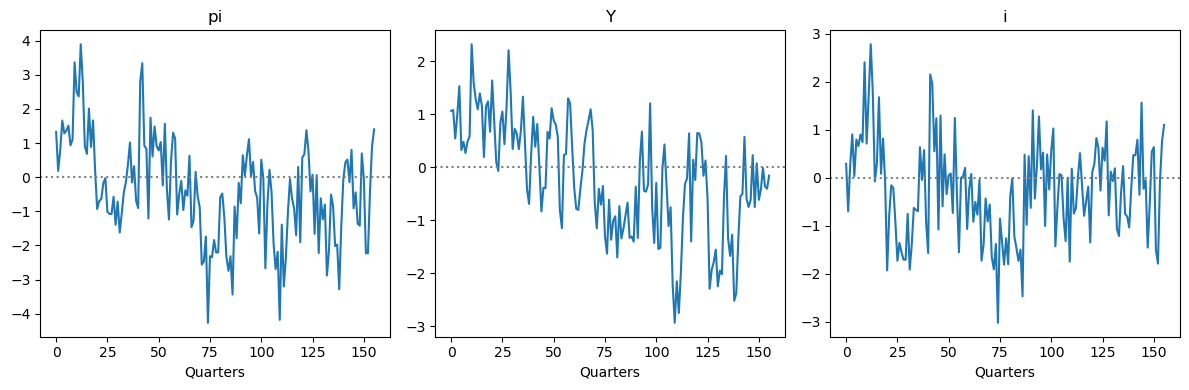

In [11]:
impulses = shocks.generate_impulses(T)
irfs = {i: G @ {i: impulses[i]} for i in inputs}

data_simul = simulate(list(irfs.values()), outputs, 156)
plot_timeseries(data_simul, figsize=(12, 4))

Y = np.empty((156, len(outputs)))
for no, o in enumerate(outputs):
    Y[:, no] = data_simul[o]

In [12]:
def log_likelihood(shock_parameters):    
    # reparameterize shocks
    shocks.reparameterize(shock_parameters)

    # construct impulse response functions
    impulses = shocks.generate_impulses(T)
    irfs = {i: G @ {i: impulses[i]} for i in inputs}
    
    M = np.empty((T, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]
    
    # approximate the autocovariances
    Sigma = sj.estimation.all_covariances(M, 1)
    
    # compute the log posterior likelihood
    loglik = sj.estimation.log_likelihood(Y, Sigma)
    logprior = shock_prior.logpdf(shock_parameters)
    
    return loglik + logprior

In [13]:
# for now construct the prior by hand
prior_support = om.Bounds(
    lower = {i: {"phi": 0.01, "sigma": 0.05} for i in inputs},
    upper = {i: {"phi": 0.99, "sigma": 1.5} for i in inputs}
)

In [14]:
result = om.maximize(
    lambda theta: log_likelihood(theta),
    shock_prior.rand(),
    bounds = prior_support,
    algorithm = "scipy_lbfgsb"
)

In [15]:
result.x

{'G': {'phi': 0.6369487558527832, 'sigma': 0.21367198316690067},
 'X': {'phi': 0.7802895036861877, 'sigma': 0.4851360516176726},
 'ishock': {'phi': 0.7119902091979626, 'sigma': 0.9885348314168728}}